In [ ]:
'''
Script - Do Not Modify

Running this cell will install all the libraries that can be used to solve this
week's Lab. You can make use of any of these libraries to help you in your code.
'''

import numpy as np
from PIL import Image
import cv2
import scipy
from scipy import signal
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

# If you get an error regarding the release version of albumentations, Ignore it.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


`cd` into the folder directory containing this notebook file and other two provided folder

In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/CIS581/CIS_5810_Project_5_Image_Morphing_Student_Files_V2

/content/drive/MyDrive/Colab Notebooks/CIS581/CIS_5810_Project_5_Image_Morphing_Student_Files_V2


# Section 1: Image morphing via triangulation

The following two helper functions are provided for you to use as you wish.

In [ ]:
'''
  Helper Function - Do Not Modify
  You can use this function in your code
'''

def matrixABC(sparse_control_points, elements):
  """
  Get the triangle matrix given three endpoint sets
  [[ax bx cx]
   [ay by cy]
   [1   1  1]]

  Input -
  sparse_control_points - sparse control points for the input image
  elements - elements (Each Simplex) of Tri.simplices

  Output -
  Stack of all [[ax bx cx]
                [ay by cy]
                [1   1  1]]
  """
  output = np.zeros((3, 3))

  # First two rows using Ax Ay Bx By Cx Cy
  for i, element in enumerate(elements):
      output[0:2, i] = sparse_control_points[element, :]

  # Fill last row with 1s
  output[2, :] = 1

  return output

In [ ]:
'''
	Helper Function - Do Not Modify
	You can use this helper function in generate_warp
'''

def interp2(v, xq, yq):
	dim_input = 1
	if len(xq.shape) == 2 or len(yq.shape) == 2:
		dim_input = 2
		q_h = xq.shape[0]
		q_w = xq.shape[1]
		xq = xq.flatten()
		yq = yq.flatten()

	h = v.shape[0]
	w = v.shape[1]
	if xq.shape != yq.shape:
		raise('query coordinates Xq Yq should have same shape')

	x_floor = np.floor(xq).astype(np.int32)
	y_floor = np.floor(yq).astype(np.int32)
	x_ceil = np.ceil(xq).astype(np.int32)
	y_ceil = np.ceil(yq).astype(np.int32)

	x_floor[x_floor < 0] = 0
	y_floor[y_floor < 0] = 0
	x_ceil[x_ceil < 0] = 0
	y_ceil[y_ceil < 0] = 0

	x_floor[x_floor >= w-1] = w-1
	y_floor[y_floor >= h-1] = h-1
	x_ceil[x_ceil >= w-1] = w-1
	y_ceil[y_ceil >= h-1] = h-1

	v1 = v[y_floor, x_floor]
	v2 = v[y_floor, x_ceil]
	v3 = v[y_ceil, x_floor]
	v4 = v[y_ceil, x_ceil]

	lh = yq - y_floor
	lw = xq - x_floor
	hh = 1 - lh
	hw = 1 - lw

	w1 = hh * hw
	w2 = hh * lw
	w3 = lh * hw
	w4 = lh * lw

	interp_val = v1 * w1 + w2 * v2 + w3 * v3 + w4 * v4

	if dim_input == 2:
		return interp_val.reshape(q_h, q_w)
	return interp_val

Please implement the `generate_warp` function below:

In [135]:
'''
Function - Modify
'''

def generate_warp(size_H, size_W,
                  Tri, ABC_Inter_inv_set,
                  ABC_im_set, image):
  """
    INPUT
      Generates warping of input image and returns the warped image
      size_H - Height of Image
      size_W -  Width of Image
      Tri - Delanauy Triangulations (generated from scipy.spatial library)
      ABC_Inter_inv_set - Stack of all Inverted ABC Matrices
      ABC_im_set - Stack of all ABC matrix triangles for the input image
      image - input image - size_H x size_W x 3
    OUPUT
      generated_pic - size_H x size_W x 3 Warped image
  """
  # TODO: Implement here
  # Generate x,y meshgrid
  x, y = np.meshgrid(np.arange(size_W), np.arange(size_H))

  # Flatten the meshgrid
  x, y = x.flatten(), y.flatten()

  # Zip the flattened x, y and Find Simplices (hint: use list and zip)
  pts = np.array(list(zip(x, y)))
  simplices = Tri.find_simplex(pts)

  # Compute alpha, beta, gamma for all the color layers(3)
  inv_ABC = ABC_Inter_inv_set[simplices]
  alpha = inv_ABC[:,0,0] * pts[:,0] + inv_ABC[:,0,1] * pts[:,1] + inv_ABC[:,0,2] * 1
  beta =  inv_ABC[:,1,0] * pts[:,0] + inv_ABC[:,1,1] * pts[:,1] + inv_ABC[:,1,2] * 1
  gamma = inv_ABC[:,2,0] * pts[:,0] + inv_ABC[:,2,1] * pts[:,1] + inv_ABC[:,2,2] * 1
  brc_coor = np.column_stack((alpha,beta,gamma))

  # Find all x and y coordinates
  pt_im = ABC_im_set[simplices] @ brc_coor[:,:,None]
  xq = pt_im[:,0,:]
  yq = pt_im[:,1,:]

  # Generate Warped Images (Use function interp2) for each of 3 layers
  generated_pic = np.zeros((size_H, size_W, 3), dtype=np.uint8)
  for i in range(3):
    channel = interp2(image[:, :, i], xq, yq)
    channel = channel.reshape(size_H, size_W)
    generated_pic[:, :, i] = channel

  return generated_pic

The following function will perform the image morphing, using your `generate_warp`. You don't need to modify this.

In [136]:
'''
Function - Do Not Modify
'''

def ImageMorphingTriangulation(im1, im2, im1_pts, im2_pts, warp_frac, dissolve_frac):
  """
    INPUT
      im1: H×W×3 numpy array representing the first image.
      im2: H×W×3 matrix representing the second image.
      im1_pts: N×2 matrix representing correspondences in the first image.
      im2_pts: N×2 matrix representing correspondences in the second image.
      warp_frac: scalar representing each frame’s shape warping parameter.
      dissolve_frac: scalar representing each frame’s cross-dissolve parameter.

    OUTPUT
      H×W×3 numpy array representing the morphed image

    Tips: Read about Delaunay function from scipy.spatial and see how you could
    use it here
  """

  # compute the H,W of the images (same size)
  size_H = im1.shape[0]
  size_W = im1.shape[1]

  # find the averagen of the sparse control points of the two images
  img_coor_inter = (1 - warp_frac)*im1_pts + warp_frac*im2_pts

  # create a new triangulation of the intermediate points
  Tri = Delaunay(img_coor_inter)

  # No. of Triangles
  nTri = Tri.simplices.shape[0]

  # Initialize the Triangle Matrices for all the triangles in image
  ABC_Inter_inv_set = np.zeros((nTri, 3, 3))
  ABC_im1_set = np.zeros((nTri, 3, 3))
  ABC_im2_set = np.zeros((nTri, 3, 3))

  for ii, element in enumerate(Tri.simplices):
    ABC_Inter_inv_set[ii, :, :] = np.linalg.inv(matrixABC(img_coor_inter, element))
    ABC_im1_set[ii, :, :] = matrixABC(im1_pts, element)
    ABC_im2_set[ii, :, :] = matrixABC(im2_pts, element)

  assert ABC_Inter_inv_set.shape[0] == nTri

  # generate warp pictures for each of the two images
  warp_im1 = generate_warp(size_H, size_W, Tri, ABC_Inter_inv_set, ABC_im1_set, im1)
  warp_im2 = generate_warp(size_H, size_W, Tri, ABC_Inter_inv_set, ABC_im2_set, im2)

  # dissolve process
  dissolved_pic = (1 - dissolve_frac) * warp_im1 + dissolve_frac * warp_im2
  dissolved_pic = dissolved_pic.astype(np.uint8)

  return dissolved_pic

Run these cells to generate and display your face morph:

In [137]:
'''
Script - Do Not Modify the script.

This script will load the images from your mounted Google Drive folder.
'''
face1 = Image.open('Project_5_Section_1/a.png')
face2 = Image.open('Project_5_Section_1/c.png')

im1 = np.array(face1)
im2 = np.array(face2)

import scipy.io
mat = scipy.io.loadmat('Project_5_Section_1/points.mat')
im1_pts = mat['Ip'] - 1
im2_pts = mat['Jp'] - 1

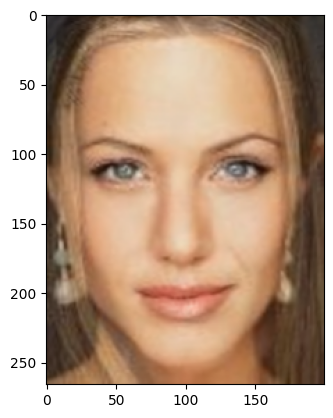

In [138]:
'''
Script - Do Not Modify (You can change the values for warp_frac and
dissolve_frac)

This script will run the Image Morphing Triangulation Function.
'''
warp_frac = 1/2
dissolve_frac = 1/2
res = ImageMorphingTriangulation(im1, im2, im1_pts, im2_pts, warp_frac, dissolve_frac)
plt.imshow(res)
plt.show()

### Tests for section 1
You will need the provided files *img0.png, img1.png, img2.png, res.npy* under `Project_5_Section_1/Project_5_Section_1_Test_Files` folder to run the tests.

In [139]:
'''
  Test cases (Run me)
'''
# Set up images and create correspondences
print('Setting up...')

im1 = np.array(Image.open('Project_5_Section_1/Project_5_Section_1_Test_Files/img0.png').convert('RGB'))
im2 = np.array(Image.open('Project_5_Section_1/Project_5_Section_1_Test_Files/img2.png').convert('RGB'))
intep_im = np.array(Image.open('Project_5_Section_1/Project_5_Section_1_Test_Files/img1.png').convert('RGB'))

im1_pts = np.array([[0, 0], [256, 0], [0, 256], [256, 256], [128, 32]])
im2_pts = np.array([[0, 0], [256, 0], [0, 256], [256, 256], [32, 128]])

size_H = im1.shape[0]
size_W = im1.shape[1]

### Test 1 ###

print('Running test 1...')

warp_frac = 0

# find the averagen of the sparse control points of the two images
img_coor_inter = (1 - warp_frac)*im1_pts + warp_frac*im2_pts
# create a new triangulation of the intermediate points
Tri = Delaunay(img_coor_inter)
# No. of Triangles
nTri = Tri.simplices.shape[0]
# Initialize the Triangle Matrices for all the triangles in image
ABC_Inter_inv_set = np.zeros((nTri, 3, 3))
ABC_im1_set = np.zeros((nTri, 3, 3))
ABC_im2_set = np.zeros((nTri, 3, 3))
for ii, element in enumerate(Tri.simplices):
  import numpy as np
  ABC_Inter_inv_set[ii, :, :] = np.linalg.inv(matrixABC(img_coor_inter, element))
  ABC_im1_set[ii, :, :] = matrixABC(im1_pts, element)
  ABC_im2_set[ii, :, :] = matrixABC(im2_pts, element)
assert ABC_Inter_inv_set.shape[0] == nTri
im3 = generate_warp(size_H, size_W, Tri, ABC_Inter_inv_set, ABC_im1_set, im1)
assert np.allclose(im1, im3, atol=5), 'Test 1 failed!'

### Test 2 ###

print('Running test 2...')

warp_frac = 1

# find the averagen of the sparse control points of the two images
img_coor_inter = (1 - warp_frac)*im1_pts + warp_frac*im2_pts
# create a new triangulation of the intermediate points
Tri = Delaunay(img_coor_inter)
# No. of Triangles
nTri = Tri.simplices.shape[0]
# Initialize the Triangle Matrices for all the triangles in image
ABC_Inter_inv_set = np.zeros((nTri, 3, 3))
ABC_im1_set = np.zeros((nTri, 3, 3))
ABC_im2_set = np.zeros((nTri, 3, 3))
for ii, element in enumerate(Tri.simplices):
	ABC_Inter_inv_set[ii, :, :] = np.linalg.inv(matrixABC(img_coor_inter, element))
	ABC_im1_set[ii, :, :] = matrixABC(im1_pts, element)
	ABC_im2_set[ii, :, :] = matrixABC(im2_pts, element)
assert ABC_Inter_inv_set.shape[0] == nTri
im3 = generate_warp(size_H, size_W, Tri, ABC_Inter_inv_set, ABC_im2_set, im2)
assert np.allclose(im2, im3, atol=5), 'Test 2 failed!'


### Test 3 ###

print('Running test 3...')

warp_frac = 0.5

# find the averagen of the sparse control points of the two images
img_coor_inter = (1 - warp_frac)*im1_pts + warp_frac*im2_pts
# create a new triangulation of the intermediate points
Tri = Delaunay(img_coor_inter)
# No. of Triangles
nTri = Tri.simplices.shape[0]
# Initialize the Triangle Matrices for all the triangles in image
ABC_Inter_inv_set = np.zeros((nTri, 3, 3))
ABC_im1_set = np.zeros((nTri, 3, 3))
ABC_im2_set = np.zeros((nTri, 3, 3))
for ii, element in enumerate(Tri.simplices):
	ABC_Inter_inv_set[ii, :, :] = np.linalg.inv(matrixABC(img_coor_inter, element))
	ABC_im1_set[ii, :, :] = matrixABC(im1_pts, element)
	ABC_im2_set[ii, :, :] = matrixABC(im2_pts, element)
assert ABC_Inter_inv_set.shape[0] == nTri
im3 = generate_warp(size_H, size_W, Tri, ABC_Inter_inv_set, ABC_im1_set, im1)
assert np.allclose(np.load('Project_5_Section_1/Project_5_Section_1_Test_Files/res.npy'), im3, atol=5), 'Test 3 failed!'

print('All passed!')

Setting up...
Running test 1...
Running test 2...
Running test 3...
All passed!


# Section 2: Animated face morphs


Run these cells before beginning section 2.

In [140]:
'''
  Import for custom morphs (run me)
'''

import imageio
import scipy.ndimage

In [141]:
'''
  Helper function (run me)
  DO NOT MODIFY
'''

def save_gif(morphed_image, fname):
  res_list = []
  k = 0
  while k < morphed_image.shape[0]:
    res_list.append(morphed_image[k, :, :, :].astype(np.uint8))
    k += 1
  imageio.mimsave(fname, res_list)

### Generating animated morphs

Please implement the function `generate_animated_morph` below:



In [147]:
'''
  Function - MODIFY
'''

def generate_animated_morph(src_im, tgt_im, src_pts, tgt_pts, M):
  """
    INPUT
      src_im: H×W×3 numpy array representing the source image (the starting frame of our morph).
      tgt_im: H×W×3 matrix representing the target image (the final frame of our morph).
      src_pts: N×2 matrix representing correspondences in the source image.
      tgt_pts: N×2 matrix representing correspondences in the target image.
      M: the number of frames to include in our animated morph.

    OUTPUT
      morphed_image: MxHxWx3 numpy array representing the M frames of the output animation, with
               each frame being an image of size HxWx3.
  """
  ## HINT: you can use the provided ImageMorphingTriangulation() function, which calls your generate_warp().
  #TODO: Implement here

  # Initialize the list to store animated frames
  morphed_frames = []
  for n in range(M):
      warp_frac = n/M
      dissolve_frac = warp_frac
      warped_image = ImageMorphingTriangulation(src_im, tgt_im, src_pts, tgt_pts, warp_frac, dissolve_frac)
      morphed_frames.append(warped_image)
  morphed_image = np.array(morphed_frames)

  return morphed_image

Test your `generate_animated_morph` function:

In [148]:
## Test generate_animated_morph()
face1 = Image.open('Project_5_Section_1/a.png')
face2 = Image.open('Project_5_Section_1/c.png')
im1 = np.array(face1)
im2 = np.array(face2)
mat = scipy.io.loadmat('Project_5_Section_1/points.mat')
im1_pts = mat['Ip'] - 1
im2_pts = mat['Jp'] - 1

print("Morphing image...")
morphed_image = generate_animated_morph(im1, im2, im1_pts, im2_pts, 30)
assert morphed_image.shape[1:] == im1.shape
assert morphed_image.shape[0] == 30
print("Done!")

# Save gif
print("Saving output...")
fname = 'output.gif'
save_gif(morphed_image, fname)
print("Output saved to", fname)

Morphing image...
Done!
Saving output...
Output saved to output.gif


### Generate custom morphs

Implement the function `rescale_image_and_points` below:




In [179]:
'''
  Function: MODIFY
'''

def rescale_image_and_points(image, points, output_shape):
  """
    INPUT
      image: H×W×3 numpy array representing the original image
      points: 32x2 matrix of (x,y) pairs
      output_shape: a tuple which represents the desired number of rows and columns,
                    respectively, for the output image

    OUTPUT
      output_image: MxN×3 numpy array representing the rescaled image, where M and N are
                    the desire number of rows and columns provided by output_shape
      output_points: the rescaled version of the input points
  """
  ## HINT: consider using the function scipy.ndimage.zoom() to rescale the image
  # TODO: Implement here
  M, N = output_shape

  output_image = scipy.ndimage.zoom(image, (M / image.shape[0], N / image.shape[1],1))
  output_points = points * np.array([N / image.shape[1], M / image.shape[0]])

  return output_image, output_points

Test your code:

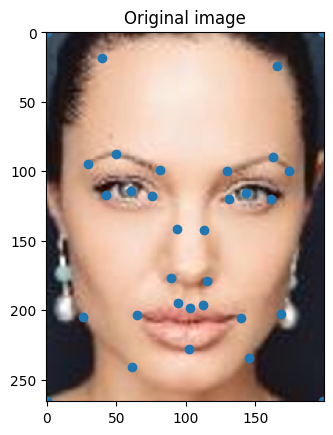

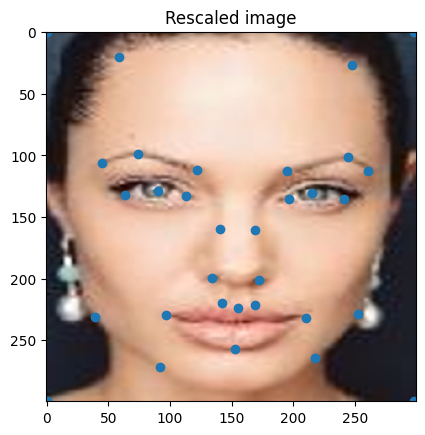

In [180]:
''' Test rescale_image_and_points() '''

image = im1
points = im1_pts
output_size = (300,300)

plt.title('Original image')
plt.imshow(image)
plt.scatter(im1_pts[:,0], im1_pts[:,1])
plt.show()

rescaled_image, rescaled_points = rescale_image_and_points(image, points, output_size)

plt.title('Rescaled image')
plt.imshow(rescaled_image)
plt.scatter(rescaled_points[:,0], rescaled_points[:,1])
plt.show()

assert rescaled_image.shape[0:2] == output_size

Finally, modify and run this script as many times as you'd like to generate your own face morphs. Please put any custom images and correspondences you would like to use in your Google drive folder under `Project_5_Section_2` directory prior to running this cell.

In [183]:
'''
  Use this script to generate your custom morphs!
'''

##
## STUDENT TODO: set your filenames, desired output size, and number of frames below
##

image1_filename = 'Project_5_Section_2/lena.jpg'
image2_filename = 'Project_5_Section_2/mona_lisa.jpg'
points1_filename = 'Project_5_Section_2/lena_points.npy'
points2_filename = 'Project_5_Section_2/mona_lisa_points.npy'
output_rows = 500
output_cols = 500
output_frames = 30

output_filename = 'custom2.gif'

##
## END STUDENT TODO
##

# Load in images and points
image1 = np.array(Image.open(image1_filename))
image2 = np.array(Image.open(image2_filename))

points1 = np.load(points1_filename)
points2 = np.load(points2_filename)

# Rescale images
image1, points1 = rescale_image_and_points(image1, points1, (output_rows,output_cols))
image2, points2 = rescale_image_and_points(image2, points2, (output_rows,output_cols))

# Morph images
print("Morphing images...")
custom_morphed_image = generate_animated_morph(image1, image2, points1, points2, output_frames)
print("Done!")

# Save gif
print("Saving output...")
save_gif(custom_morphed_image, output_filename)
print("Output saved to", output_filename)

Morphing images...
Done!
Saving output...
Output saved to custom2.gif
